In [ ]:
from craigslist import CraigslistHousing

In [ ]:
BOXES = { "trial_area": [[37.756005, -122.435709],[37.794899, -122.387901]] }

In [ ]:
def in_box(coords, box):
    if box[0][0] < coords[0] and  coords[0] < box[1][0] and box[1][1] > coords[1] and coords[1] < box[0][1]:
        return True
    return False
geotag = result["geotag"]
area_found = False
area = ""
for a, coords in BOXES.items():
    if in_box(geotag, coords):
        area = a
        area_found = True

In [ ]:
NEIGHBORHOODS = ["trial_area" ]

In [ ]:
location = result["where"]
for hood in NEIGHBORHOODS:
    if hood in location.lower():
        area = hood

In [ ]:
# test_coord = (37.783808, -122.399056)
# area_found = False
# area = ""
# for a, coords in BOXES.items():
#     if in_box(geotag, coords):
#         area = a
#         area_found = True
# print(area_found)

In [ ]:
cl = CraigslistHousing(site='sfbay', area='sfc', category='apa',                         filters={'max_price': 4500, 'min_price': 3000})
results = cl.get_results(sort_by='newest', geotagged=True, limit=10000)
for result in results:
    geotag = result["geotag"]
    if (len(geotag) == 2):
        area_found = False
        for a, coords in BOXES.items():
            if in_box(geotag, coords):
                area = a
                area_found = True
        if area_found:
            print(result)
    

In [ ]:
print(result)

In [ ]:
from selenium import webdriver
from bs4 import BeautifulSoup
import time
from bs4.element import Tag

driver = webdriver.Chrome('/home/francis/chromedriver')
driver.get('https://raleigh.craigslist.org/search/rea?query=duplex&sort=date&availabilityMode=0&sale_date=all+dates')
time.sleep(3)

soup = BeautifulSoup(driver.page_source,'lxml')
rowArray = soup.find_all("li", { "class":"result-row"})

for row in rowArray:
    img = row.find("img")
    if img is None:
        continue
    if isinstance(img,Tag) and img.has_attr("src"):
        print(img['src'])
        print("----------------") 

In [1]:
from selenium import webdriver

driver = webdriver.Chrome(executable_path='/home/francis/chromedriver')
driver.get("http://www.python.org")

ModuleNotFoundError: No module named 'selenium'

In [2]:
#import get to call a get request on the site
from requests import get

#get the first page of the east bay housing prices
response = get('https://sfbay.craigslist.org/search/hhh?s=120&availabilityMode=0&max_bedrooms=2&max_price=4500&min_bedrooms=2&postal=94117&search_distance=1.5') #get rid of those lame-o's that post a housing option without a pic using their filter

from bs4 import BeautifulSoup
html_soup = BeautifulSoup(response.text, 'html.parser')

#get the macro-container for the housing posts
posts = html_soup.find_all('li', class_= 'result-row')

In [3]:
#build out the loop
from time import sleep
import re
from random import randint #avoid throttling by not sending too many requests one after the other
from warnings import warn
from time import time
from IPython.core.display import clear_output
import numpy as np

#find the total number of posts to find the limit of the pagination
results_num = html_soup.find('div', class_= 'search-legend')
results_total = int(results_num.find('span', class_='totalcount').text) #pulled the total count of posts as the upper bound of the pages array

#each page has 119 posts so each new page is defined as follows: s=120, s=240, s=360, and so on. So we need to step in size 120 in the np.arange function
pages = np.arange(0, results_total+1, 120)

iterations = 0

post_timing = []
post_hoods = []
post_title_texts = []
bedroom_counts = []
sqfts = []
post_links = []
post_prices = []

for page in pages:
    print("page " + str(page) )
    #get request
    response = get("https://sfbay.craigslist.org/search/hhh?" 
                   + "s=" #the parameter for defining the page number 
                   + str(page) #the page number in the pages array from earlier
                   + "&availabilityMode=0&max_bedrooms=2&max_price=4500&min_bedrooms=2&postal=94117&search_distance=1.5")

    sleep(randint(1,5))
     
    #throw warning for status codes that are not 200
    if response.status_code != 200:
        warn('Request: {}; Status code: {}'.format(requests, response.status_code))
        
    #define the html text
    page_html = BeautifulSoup(response.text, 'html.parser')
    
    #define the posts
    posts = html_soup.find_all('li', class_= 'result-row')
        
    #extract data item-wise
    for post in posts:

        if post.find('span', class_ = 'result-hood') is not None:

            #posting date
            #grab the datetime element 0 for date and 1 for time
            post_datetime = post.find('time', class_= 'result-date')['datetime']
            post_timing.append(post_datetime)

            #neighborhoods
            post_hood = post.find('span', class_= 'result-hood').text
            post_hoods.append(post_hood)

            #title text
            post_title = post.find('a', class_='result-title hdrlnk')
            post_title_text = post_title.text
            post_title_texts.append(post_title_text)

            #post link
            post_link = post_title['href']
            post_links.append(post_link)
            
            #removes the \n whitespace from each side, removes the currency symbol, and turns it into an int
            try:
                post_price = int(post.a.text.strip().replace("$", "")) 
                post_prices.append(post_price)
            except ValueError as e:
                print("error",e)
                post_prices.append(0)
            
            if post.find('span', class_ = 'housing') is not None:
                
                #if the first element is accidentally square footage
                if 'ft2' in post.find('span', class_ = 'housing').text.split()[0]:
                    
                    #make bedroom nan
                    bedroom_count = np.nan
                    bedroom_counts.append(bedroom_count)
                    
                    #make sqft the first element
                    sqft = int(post.find('span', class_ = 'housing').text.split()[0][:-3])
                    sqfts.append(sqft)
                    
                #if the length of the housing details element is more than 2
                elif len(post.find('span', class_ = 'housing').text.split()) > 2:
                    
                    #therefore element 0 will be bedroom count
                    bedroom_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
                    bedroom_counts.append(bedroom_count)
                    
                    #and sqft will be number 3, so set these here and append
                    sqft = int(post.find('span', class_ = 'housing').text.split()[2][:-3])
                    sqfts.append(sqft)
                    
                #if there is num bedrooms but no sqft
                elif len(post.find('span', class_ = 'housing').text.split()) == 2:
                    
                    #therefore element 0 will be bedroom count
                    bedroom_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
                    bedroom_counts.append(bedroom_count)
                    
                    #and sqft will be number 3, so set these here and append
                    sqft = np.nan
                    sqfts.append(sqft)                    
                
                else:
                    bedroom_count = np.nan
                    bedroom_counts.append(bedroom_count)
                
                    sqft = np.nan
                    sqfts.append(sqft)
                
            #if none of those conditions catch, make bedroom nan, this won't be needed    
            else:
                bedroom_count = np.nan
                bedroom_counts.append(bedroom_count)
                
                sqft = np.nan
                sqfts.append(sqft)
            #    bedroom_counts.append(bedroom_count)
                
            #    sqft = np.nan
            #    sqfts.append(sqft)
                
    iterations += 1
    print("Page " + str(iterations) + " scraped successfully!")

print("\n")

print("Scrape complete!")

page 0
error invalid literal for int() with base 10: ''
error invalid literal for int() with base 10: ''
error invalid literal for int() with base 10: ''
error invalid literal for int() with base 10: ''
Page 1 scraped successfully!
page 120
error invalid literal for int() with base 10: ''
error invalid literal for int() with base 10: ''
error invalid literal for int() with base 10: ''
error invalid literal for int() with base 10: ''
Page 2 scraped successfully!
page 240
error invalid literal for int() with base 10: ''
error invalid literal for int() with base 10: ''
error invalid literal for int() with base 10: ''
error invalid literal for int() with base 10: ''
Page 3 scraped successfully!


Scrape complete!


In [4]:

import pandas as pd

eb_apts = pd.DataFrame({'posted': post_timing,
                       'neighborhood': post_hoods,
                       'post title': post_title_texts,
                       'number bedrooms': bedroom_counts,
                        'sqft': sqfts,
                        'URL': post_links,
                       'price': post_prices})
print(eb_apts.info())
eb_apts.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   posted           351 non-null    object 
 1   neighborhood     351 non-null    object 
 2   post title       351 non-null    object 
 3   number bedrooms  351 non-null    object 
 4   sqft             135 non-null    float64
 5   URL              351 non-null    object 
 6   price            351 non-null    int64  
dtypes: float64(1), int64(1), object(5)
memory usage: 19.3+ KB
None


,posted,neighborhood,post title,number bedrooms,sqft,URL,price
0,2020-05-03 05:47,(Lower Pacific Heights),"Epic REA-Azai PM Nice 2BR/1BA, Free Pkg, Yard,...",2,1000.0,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,3995
1,2020-05-03 05:47,(Lower Pacific Heights),"Epic REA-Azai PM Nice 2BR/1BA, Free Pkg, Yard,...",2,1000.0,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,3995
2,2020-05-03 08:26,(noe valley),Present PM-Brand New Noe Valley Stunner--Views...,2,975.0,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,4500
3,2020-05-02 19:30,(castro / upper market),The Prettiest Tree-Lined Street-Blocks to Dolo...,2,NaN,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,4500
4,2020-05-01 09:40,(hayes valley),2 Bedroom Townhome Offering 1.5 Month Rent FRE...,2,988.0,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,4390
5,2020-05-02 18:56,(lower pac hts),"$3995. 2Bed 1BATH,H/W,D/W ,FREE PARKING @@@@@...",2,NaN,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,3995
6,2020-05-02 18:36,(lower pac hts),"2 Bed/1 Bath, Top Floor, H/W, D/W, One free pa...",2,NaN,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,4195
7,2020-05-01 19:19,(lower pac hts),"$3995. 2Bed 1BATH,H/W,D/W ,FREE PARKING @@@@@...",2,NaN,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,3995
8,2020-04-30 09:20,(lower pac hts),"$3995. 2Bed 1BATH,H/W,D/W ,FREE PARKING @@@@@...",2,NaN,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,3995
9,2020-04-30 09:09,(lower pac hts),"2 Bed/1 Bath, Top Floor, H/W, D/W, One free pa...",2,NaN,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,4195


In [5]:
#first things first, drop duplicate URLs because people are spammy on Craigslist. 
#Let's see how many uniqe posts we really have.
eb_apts = eb_apts.drop_duplicates(subset='URL')
len(eb_apts.drop_duplicates(subset='URL'))

#make the number bedrooms to a float (since np.nan is a float too)
eb_apts['number bedrooms'] = eb_apts['number bedrooms'].apply(lambda x: float(x))

#convert datetime string into datetime object to be able to work with it
from datetime import datetime

eb_apts['posted'] = pd.to_datetime(eb_apts['posted'])

#Looking at what neighborhoods there are with eb_apts['neighborhood'].unique() allowed me to see what
#I needed to deal with in terms of cleaning those.

#remove the parenthesis from the left and right of the neighborhoods
eb_apts['neighborhood'] = eb_apts['neighborhood'].map(lambda x: x.lstrip('(').rstrip(')'))

#titlecase them
eb_apts['neighborhood'] = eb_apts['neighborhood'].str.title()

#just take the first name of the neighborhood list, splitting on the '/' delimiter
eb_apts['neighborhood'] = eb_apts['neighborhood'].apply(lambda x: x.split('/')[0])

#fix one-offs that
eb_apts['neighborhood'].replace('Belmont, Ca', 'Belmont', inplace=True)
eb_apts['neighborhood'].replace('Hercules, Pinole, San Pablo, El Sob', 'Hercules', inplace=True)

#remove whitespaces
eb_apts['neighborhood'] = eb_apts['neighborhood'].apply(lambda x: x.strip())

#save the clean data
eb_apts.to_csv("eb_apts_1642_Jan_2_19_clean.csv", index=False)

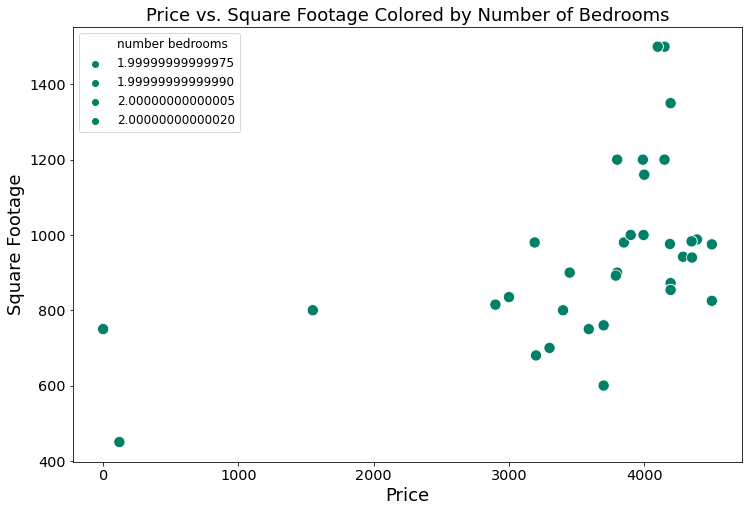

In [6]:
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import seaborn as sns
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

plt.figure(figsize=(12, 8))
sns.scatterplot(x='price', y='sqft', hue='number bedrooms', palette='summer', x_jitter=True, y_jitter=True, s=125, data=eb_apts.dropna())
plt.legend(fontsize=12)
plt.xlabel("Price", fontsize=18)
plt.ylabel("Square Footage", fontsize=18);
plt.title("Price vs. Square Footage Colored by Number of Bedrooms", fontsize=18);

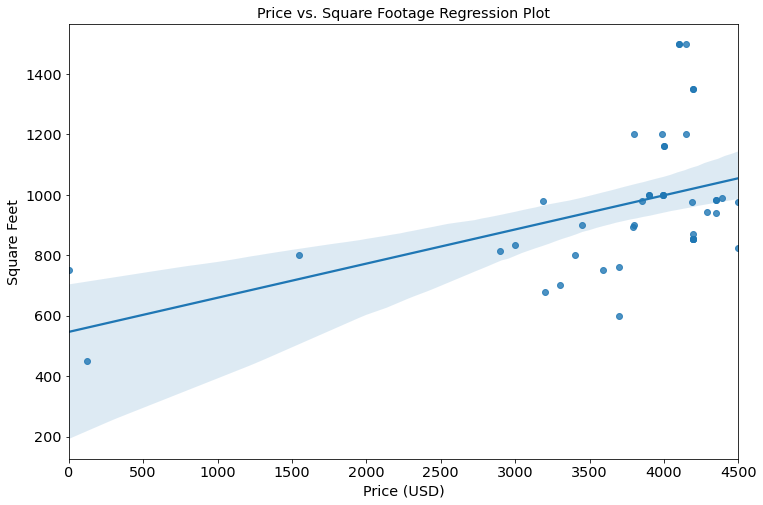

In [7]:
plt.figure(figsize=(12, 8))
sns.regplot(x='price', y='sqft', data=eb_apts.dropna());
plt.title('Price vs. Square Footage Regression Plot');
plt.xlabel("Price (USD)");
plt.ylabel("Square Feet");

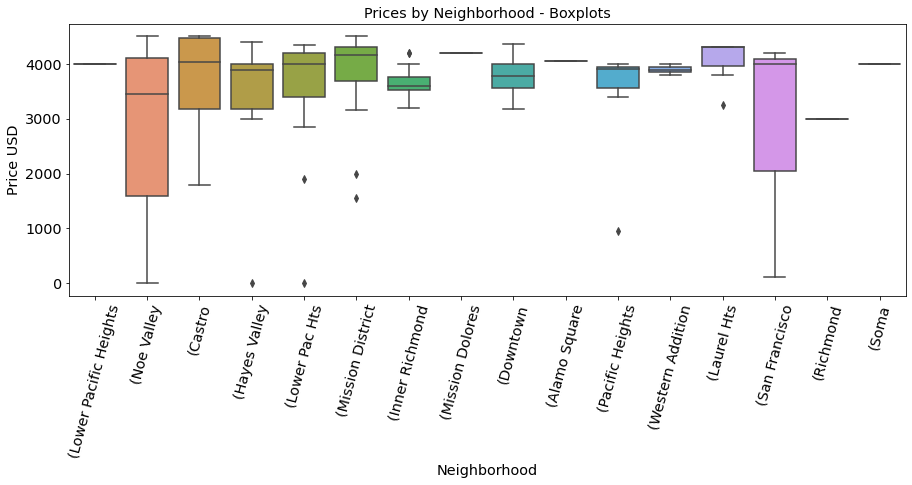

In [8]:

sns.boxplot(x='neighborhood', y='price', data=eb_apts)
plt.xlabel("Neighborhood");
plt.xticks(rotation=75)
plt.ylabel("Price USD");
plt.title("Prices by Neighborhood - Boxplots");